In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/huge-stock-market-crash-2022/stock_market_crash_2022.csv


In [93]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import re
import nltk
import gensim
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import warnings
warnings.filterwarnings('ignore')

In [100]:
df=pd.read_csv('/kaggle/input/huge-stock-market-crash-2022/stock_market_crash_2022.csv')

In [101]:
df.shape

(33946, 18)

In [102]:
df.head()

,id,text,text_sentiment,username,hashtags,created_at,user followers count,replycount,retweetcount,likecount,quotecount,language,media,retweetedTweet,quotedtweet,inReplyToTweetId,inReplyToUser,mentionedUsers
0,1538666561615015938,When will the #NYSE #stockmarketcrash happen?,Neutral,tradexlnc,"['NYSE', 'stockmarketcrash']",2022-06-19 23:34:29+00:00,10669,0,0,1,0,en,NaN,NaN,NaN,NaN,NaN,NaN
1,1538665013799489536,Aaj ka gyan:\n\nIf a company isn't a quality c...,Negative,niftymonday,"['stockmarkets', 'stockmarketcrash', 'trading'...",2022-06-19 23:28:20+00:00,100,0,1,8,0,en,NaN,NaN,NaN,NaN,NaN,NaN
2,1538660868027830274,The stock market needs to crash hard to make i...,Negative,kyle132313,"['stockmarketcrash', 'economy', 'rich', 'Fed']",2022-06-19 23:11:52+00:00,0,0,0,0,0,en,NaN,NaN,NaN,NaN,NaN,NaN
3,1538657239849836544,"Those who are ""Buying on DIP"" will very soon b...",Neutral,ChintanRajput16,"['stockmarketcrash', 'StocksToBuy', 'stockstow...",2022-06-19 22:57:27+00:00,54,0,2,2,0,en,NaN,NaN,NaN,NaN,NaN,NaN
4,1538654339044196358,@rdrhwke I wish our so-called President were t...,Positive,DrPCJustice,"['Bidenomics', 'inflation', 'recession', 'stoc...",2022-06-19 22:45:55+00:00,28,0,0,0,0,en,NaN,NaN,NaN,1.538653e+18,https://twitter.com/rdrhwke,"[User(username='rdrhwke', id=43753976, display..."


The dataset seems to consist of tweets with various fields such as text, sentiment, username, hashtags, and other Twitter-related metadata.
With 33,945 rows and 18 columns, the dataset provides a substantial amount of information for analysis.

In [103]:
df["text_sentiment"].unique()

array(['Neutral', 'Negative', 'Positive'], dtype=object)

# There is only 3 sentiments for text so it's gonna be our target in futureThere are only three sentiments for the text, so these will be our target categories for future analysis.

In [97]:
df.isnull().sum()

id                          0
text                        0
text_sentiment              0
username                    0
hashtags                    1
created_at                  0
user followers count        0
replycount                  0
retweetcount                0
likecount                   0
quotecount                  0
language                    0
media                   33946
retweetedTweet          33946
quotedtweet             33946
inReplyToTweetId        28998
inReplyToUser           28998
mentionedUsers          28413
dtype: int64

# Most of the metadata associated with tweets are null, which suggests they may not be necessary for our purposes, and thus we can drop them. 

In [ ]:
df = df.dropna(subset=['hashtags'])

In [104]:
columns_to_drop = ['media','retweetedTweet', 'quotedtweet','inReplyToTweetId','inReplyToUser','mentionedUsers']
df = df.drop(columns=columns_to_drop)

In [99]:
df.head()

,id,text,text_sentiment,username,hashtags,created_at,user followers count,replycount,retweetcount,likecount,quotecount,language,media
0,1538666561615015938,When will the #NYSE #stockmarketcrash happen?,Neutral,tradexlnc,"['NYSE', 'stockmarketcrash']",2022-06-19 23:34:29+00:00,10669,0,0,1,0,en,NaN
1,1538665013799489536,Aaj ka gyan:\n\nIf a company isn't a quality c...,Negative,niftymonday,"['stockmarkets', 'stockmarketcrash', 'trading'...",2022-06-19 23:28:20+00:00,100,0,1,8,0,en,NaN
2,1538660868027830274,The stock market needs to crash hard to make i...,Negative,kyle132313,"['stockmarketcrash', 'economy', 'rich', 'Fed']",2022-06-19 23:11:52+00:00,0,0,0,0,0,en,NaN
3,1538657239849836544,"Those who are ""Buying on DIP"" will very soon b...",Neutral,ChintanRajput16,"['stockmarketcrash', 'StocksToBuy', 'stockstow...",2022-06-19 22:57:27+00:00,54,0,2,2,0,en,NaN
4,1538654339044196358,@rdrhwke I wish our so-called President were t...,Positive,DrPCJustice,"['Bidenomics', 'inflation', 'recession', 'stoc...",2022-06-19 22:45:55+00:00,28,0,0,0,0,en,NaN


In [105]:
 df.duplicated().sum()

300

# There are 300 rows that are duplicated, representing less than 1% of our dataset; therefore, we can simply remove them.

In [33]:
df=df.drop_duplicates()

In [6]:
tags = df.hashtags

In [9]:
def tags_to_list(tags):
    tag_list = re.findall(r'[A-Za-z]+',str(tags))
    return tag_list
tags = tags.apply(tags_to_list)
tags.head()

0                             [NYSE, stockmarketcrash]
1    [stockmarkets, stockmarketcrash, trading, inve...
2               [stockmarketcrash, economy, rich, Fed]
3       [stockmarketcrash, StocksToBuy, stockstowatch]
4    [Bidenomics, inflation, recession, stockmarket...
Name: hashtags, dtype: object

In [10]:
# get most frequent k words
def tags_freq_dict(tags,k):
    tags_freq = {}
    for tag_words_list in tags:
        for tag_words in tag_words_list:
            if tag_words not in tags_freq:
                tags_freq[tag_words] = 0
            tags_freq[tag_words] += 1
    tags_freq = sorted(tags_freq.items(),key = lambda kv:kv[1],reverse=True)
    k_freq_words = (tags_freq[i] for i in range(k))
    k_freq_words = dict(k_freq_words)
    return k_freq_words

In [117]:
# figure of the 10 most frequent words
most_freq_words = tags_freq_dict(tags,10)
plt.figure(dpi = 1500)
plt.grid(visible = False)
plt.bar(most_freq_words.keys(),most_freq_words.values(),color = 'blue')
plt.tick_params(labelsize=5)  
plt.xlabel('tags_words',fontsize = 7,loc = 'right')
plt.ylabel('frequency',fontsize = 7,loc = 'top')
plt.title('10 Most Frequent Words in Hashtags',fontsize = 10)
plt.show()

# Based on the provided plot above, the most frequent hashtags are #stockmarketcrash and #bearmarket. This indicates that people are often more affected by negative emotions than positive ones.

In [107]:
df['text_length'] = df['text'].apply(len)
df['text_length'].describe()

count    33946.000000
mean       150.385112
std         75.362411
min         11.000000
25%         89.000000
50%        138.000000
75%        212.000000
max        434.000000
Name: text_length, dtype: float64

In [108]:
# Descriptive statistics for text length
text_length_stats = df['text_length'].describe()

# Identifying abnormally long or short tweets
# Using 1.5*IQR to define outliers
Q1 = text_length_stats['25%']
Q3 = text_length_stats['75%']
IQR = Q3 - Q1
outlier_threshold_low = Q1 - 1.5 * IQR
outlier_threshold_high = Q3 + 1.5 * IQR

# Counting outliers
num_short_outliers = df[df['text_length'] < outlier_threshold_low].shape[0]
num_long_outliers = df[df['text_length'] > outlier_threshold_high].shape[0]

# Calculating the ratio of disaster to non-disaster tweets
disaster_ratio = df['text_sentiment'].value_counts(normalize=True) * 100

# Random sample of tweets for manual inspection
sample_tweets = df[['text', 'text_sentiment']].sample(5)

# Displaying the results
print("Text Length Statistics:\n", text_length_stats)
print("\nOutlier Thresholds: Low =", outlier_threshold_low, ", High =", outlier_threshold_high)
print("\nNumber of Short Outliers:", num_short_outliers)
print("Number of Long Outliers:", num_long_outliers)
print("\Sentiment Ratio:\n", disaster_ratio)
print("\nSample News:\n", sample_tweets)

Text Length Statistics:
 count    33946.000000
mean       150.385112
std         75.362411
min         11.000000
25%         89.000000
50%        138.000000
75%        212.000000
max        434.000000
Name: text_length, dtype: float64

Outlier Thresholds: Low = -95.5 , High = 396.5

Number of Short Outliers: 0
Number of Long Outliers: 1
\Sentiment Ratio:
 text_sentiment
Positive    36.946916
Neutral     33.871443
Negative    29.181641
Name: proportion, dtype: float64

Sample News:
                                                     text text_sentiment
29928  Both market cycles begin with the alphabet "B"...       Negative
26072  @killabearsnft @NoccoOG Insane ! This is by fa...       Positive
27609  Do you think $LUNA will hit $1 within one week...        Neutral
12329  INOXWIND BUY ABOVE 114.20\nSL 113\nTARGET 115....        Neutral
18563  Stock Market ~ Fear of the unknown.\n#stockmar...       Negative


# Above, we observed that there is one tweet that stands out as an outlier in our dataset. We can also see that there are more positive tweets than negative or neutral ones.

In [109]:
# Identifying outliers
outliers = df[(df['text_length'] < outlier_threshold_low) | (df['text_length'] > outlier_threshold_high)]


if not outliers.empty:
    outlier_tweet = outliers.iloc[0]['text']
    print("Outlier tweet:", outlier_tweet)
else:
    print("No outliers found")

Outlier tweet: @GertvanLagen @TechDev_52 @MatthewHyland_ @MattchengBtm @therationalroot @Gdudocq @EtherNasyonaL @CalebFranzen @IT_Tech_PL @JustinBennettFX @TheRealPlanC Anything is possible. But this is very optimistic in the short term. #BTC still hasn't seen a capitulation move yet in this #bearmarket. Institutions want in but not at these prices I expect to see maximum pain first. I'm long and I will #HODL but opportunity lies in lower prices


We can drop this tweet

In [110]:
df_filtered = df[(df['text_length'] >= outlier_threshold_low) & (df['text_length'] <= outlier_threshold_high)]


In [111]:
df_filtered.head()

,id,text,text_sentiment,username,hashtags,created_at,user followers count,replycount,retweetcount,likecount,quotecount,language,text_length
0,1538666561615015938,When will the #NYSE #stockmarketcrash happen?,Neutral,tradexlnc,"['NYSE', 'stockmarketcrash']",2022-06-19 23:34:29+00:00,10669,0,0,1,0,en,45
1,1538665013799489536,Aaj ka gyan:\n\nIf a company isn't a quality c...,Negative,niftymonday,"['stockmarkets', 'stockmarketcrash', 'trading'...",2022-06-19 23:28:20+00:00,100,0,1,8,0,en,223
2,1538660868027830274,The stock market needs to crash hard to make i...,Negative,kyle132313,"['stockmarketcrash', 'economy', 'rich', 'Fed']",2022-06-19 23:11:52+00:00,0,0,0,0,0,en,259
3,1538657239849836544,"Those who are ""Buying on DIP"" will very soon b...",Neutral,ChintanRajput16,"['stockmarketcrash', 'StocksToBuy', 'stockstow...",2022-06-19 22:57:27+00:00,54,0,2,2,0,en,133
4,1538654339044196358,@rdrhwke I wish our so-called President were t...,Positive,DrPCJustice,"['Bidenomics', 'inflation', 'recession', 'stoc...",2022-06-19 22:45:55+00:00,28,0,0,0,0,en,171


Let's now check hastags

In [112]:
import ast


# Function to safely convert string to list
def string_to_list(string):
    try:
        return ast.literal_eval(string)
    except (ValueError, SyntaxError):
        return []  # Return an empty list in case of an error


In [113]:
df_filtered['hashtags'] = df_filtered['hashtags'].apply(string_to_list)
df_filtered['hashtags_length'] = df_filtered['hashtags'].apply(len)
df_filtered['hashtags_length'].describe()

count    33945.000000
mean         3.333304
std          2.381847
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         22.000000
Name: hashtags_length, dtype: float64

In [114]:
hashtags_length_stats = df_filtered['hashtags_length'].describe()

# Calculate IQR
Q1 = hashtags_length_stats['25%']
Q3 = hashtags_length_stats['75%']
IQR = Q3 - Q1

# Determine outlier thresholds
outlier_threshold_low = Q1 - 1.5 * IQR
outlier_threshold_high = Q3 + 1.5 * IQR

# Count outliers
num_short_outliers = df_filtered[df_filtered['hashtags_length'] < outlier_threshold_low].shape[0]
num_long_outliers = df_filtered[df_filtered['hashtags_length'] > outlier_threshold_high].shape[0]

# Display the results
print("Hashtag Length Statistics:\n", hashtags_length_stats)
print("\nOutlier Thresholds: Low =", outlier_threshold_low, ", High =", outlier_threshold_high)
print("\nNumber of Short Outliers:", num_short_outliers)
print("Number of Long Outliers:", num_long_outliers)

Hashtag Length Statistics:
 count    33945.000000
mean         3.333304
std          2.381847
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         22.000000
Name: hashtags_length, dtype: float64

Outlier Thresholds: Low = -1.0 , High = 7.0

Number of Short Outliers: 0
Number of Long Outliers: 2084


2084 of long outliers let's print them

In [115]:
top_long_outliers = df_filtered[df_filtered['hashtags_length'] > outlier_threshold_high].nlargest(10, 'hashtags_length')

# Step 2: Extract the text associated with these outliers
top_long_outliers_text = top_long_outliers['text'] 


# Step 4: Read their text
for index, text in top_long_outliers_text.items():
    print(f"Index: {index}, Text: {text}",end='\n\n')

Index: 21454, Text: #cryptocrash #Cryptocrash #Ethereumcrash #cryptovaluation #Celsius #Celsiusnetwork #DeFi #Luna  #crypto #bitcoin #cryptocurrency #blockchain #ethereum #btc #forex #trading #money #cryptonews #cryptotrading #cryptocurrencies #investing #bearmarket

Index: 22977, Text: This week, $BTC 18k, $ETH 800
#gods  #godsunchained #btc   #ETH #LUNC #LUNA Celsius $CEL  #TRX #SOL #Doge #SHIBA #DOT #AVAX   #WAVES #APECOIN #BNB  #Tesla $SOL $GODS $LUNA #cryptocurrency #Crypto $TSLA $WAVES cryptocurrency tesla #FED #inflation #Cryptocrash #bearmarket

Index: 29199, Text: Aan alle mensen die Eind vorig jaar in crypto zijn gestapt: sterkte. Mijn god wat een ellende... #crypto #currency #cryptocurrency #bitcoin #museumplein #maud #brobbey #crash #cryptomarket #bull #whales #bullrun #bear #bearmarket #whale #buy #sell #hodl #hold #fomo #blsh

Index: 31754, Text: Selling #bitcoin    is the biggest mistake of your life. 💸
 #HODL #investing #altcoinseason #buythedip #Hodling #Etherum #bearm

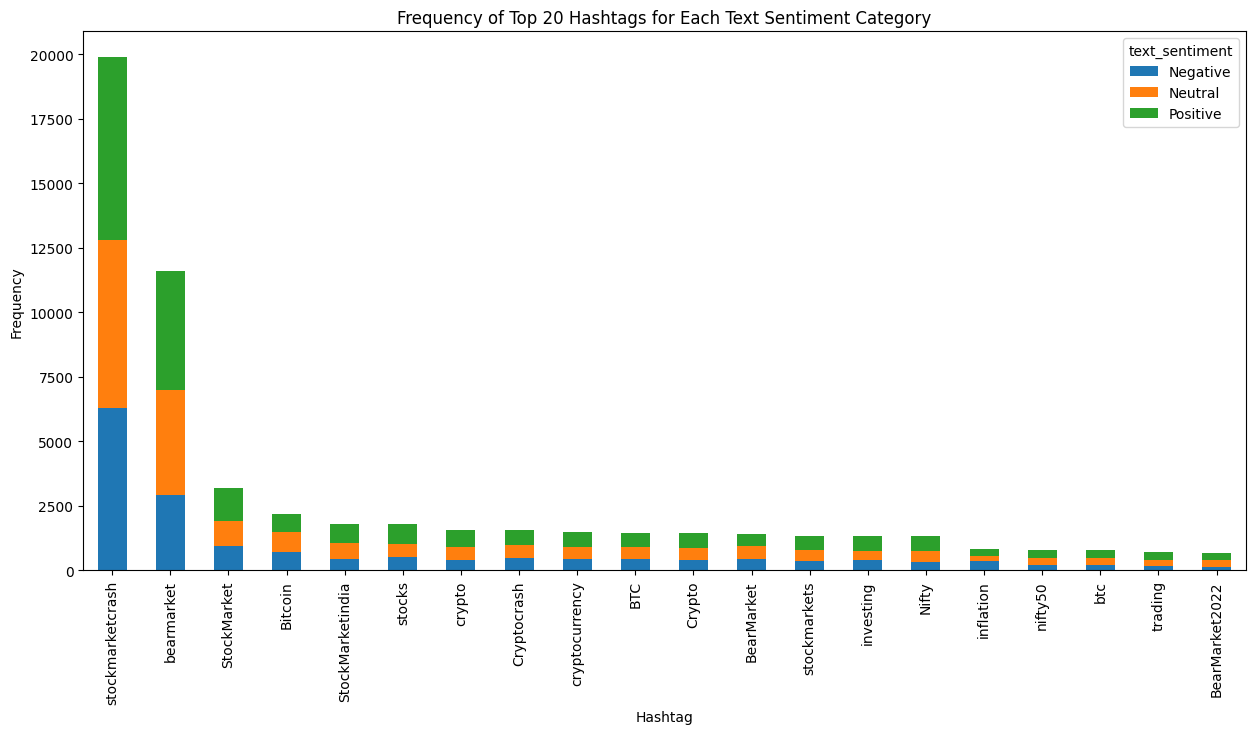

In [116]:
from collections import Counter

# Flatten the list of hashtags and count frequencies
all_hashtags = [hashtag for hashtags in df_filtered['hashtags'] for hashtag in hashtags]
hashtag_counts = Counter(all_hashtags)

# Identify the top 20 hashtags
top_20_hashtags = [hashtag for hashtag, count in hashtag_counts.most_common(20)]

# Filter the DataFrame to include only rows where the hashtag list 
# contains at least one of the top 20 hashtags
df_filtered_20 = df_filtered[df_filtered['hashtags'].apply(lambda x: any(hashtag in x for hashtag in top_20_hashtags))]

# Mapping top 20 hashtags to integers
hashtag_to_int_top_20 = {hashtag: i for i, hashtag in enumerate(top_20_hashtags)}
df_filtered_20['hashtag_map'] = df_filtered_20['hashtags'].apply(lambda x: [hashtag_to_int_top_20[ht] for ht in x if ht in hashtag_to_int_top_20])

# Explode the DataFrame so each hashtag has its own row
df_filtered_20_exploded = df_filtered_20.explode('hashtag_map')

# Calculate frequency of each hashtag for each text sentiment category
hashtag_sentiment_frequency = df_filtered_20_exploded.groupby(['hashtag_map', 'text_sentiment']).size().unstack(fill_value=0)

# Plotting for the top 20 hashtags
hashtag_sentiment_frequency.plot(kind='bar', stacked=True, figsize=(15, 7))
plt.xlabel('Hashtag')
plt.ylabel('Frequency')
plt.title('Frequency of Top 20 Hashtags for Each Text Sentiment Category')
plt.xticks(ticks=range(len(top_20_hashtags)), labels=top_20_hashtags, rotation=90)  # Adjusting x-axis labels
plt.show()

# The sentiment distribution appears balanced, and there are also some individuals who are neutral regarding the stock market crash or who bet against the market.

In [124]:
df_filtered_20.head()

,id,text,text_sentiment,username,hashtags,created_at,user followers count,replycount,retweetcount,likecount,quotecount,language,text_length,hashtags_length,hashtag_map
0,1538666561615015938,When will the #NYSE #stockmarketcrash happen?,Neutral,tradexlnc,"[NYSE, stockmarketcrash]",2022-06-19 23:34:29+00:00,10669,0,0,1,0,en,45,2,[0]
1,1538665013799489536,Aaj ka gyan:\n\nIf a company isn't a quality c...,Negative,niftymonday,"[stockmarkets, stockmarketcrash, trading, inve...",2022-06-19 23:28:20+00:00,100,0,1,8,0,en,223,6,"[12, 0, 18, 13]"
2,1538660868027830274,The stock market needs to crash hard to make i...,Negative,kyle132313,"[stockmarketcrash, economy, rich, Fed]",2022-06-19 23:11:52+00:00,0,0,0,0,0,en,259,4,[0]
3,1538657239849836544,"Those who are ""Buying on DIP"" will very soon b...",Neutral,ChintanRajput16,"[stockmarketcrash, StocksToBuy, stockstowatch]",2022-06-19 22:57:27+00:00,54,0,2,2,0,en,133,3,[0]
4,1538654339044196358,@rdrhwke I wish our so-called President were t...,Positive,DrPCJustice,"[Bidenomics, inflation, recession, stockmarket...",2022-06-19 22:45:55+00:00,28,0,0,0,0,en,171,4,"[15, 0]"


In [126]:
hashtag_to_int_top_20

{'stockmarketcrash': 0,
 'bearmarket': 1,
 'StockMarket': 2,
 'Bitcoin': 3,
 'StockMarketindia': 4,
 'stocks': 5,
 'crypto': 6,
 'Cryptocrash': 7,
 'cryptocurrency': 8,
 'BTC': 9,
 'Crypto': 10,
 'BearMarket': 11,
 'stockmarkets': 12,
 'investing': 13,
 'Nifty': 14,
 'inflation': 15,
 'nifty50': 16,
 'btc': 17,
 'trading': 18,
 'BearMarket2022': 19}

In [139]:
def count_hashtag_on_sentiments(df, hashtag_to_int, hashtag):
    if hashtag not in hashtag_to_int:
        return f"Hashtag '{hashtag}' is not in the top hashtags list."
    
    hashtag_id = hashtag_to_int[hashtag]
    df_hashtag = df[df['hashtag_map'].apply(lambda tags: hashtag_id in tags)]
    sentiment_counts = df_hashtag['text_sentiment'].value_counts().reindex(['Negative', 'Positive', 'Neutral'], fill_value=0).to_dict()
    
    return sentiment_counts


In [141]:
count_hashtag_on_sentiments(df_filtered_20,hashtag_to_int_top_20,'stockmarketcrash')

{'Negative': 6276, 'Positive': 7081, 'Neutral': 6503}

In [142]:
count_hashtag_on_sentiments(df_filtered_20,hashtag_to_int_top_20,'bearmarket')

{'Negative': 2918, 'Positive': 4605, 'Neutral': 4065}

# They are more positives tweets than negative in market crash ,it might be sarcasm or satire